In [133]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import datasets, transforms, utils

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime
import os
from math import sqrt
import sys

# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)
    
# I also define a function we use to examine the outputs of the Generator
def show_images(images, num_images=16, figsize=(10,10)):
    # Ensure the input is on CPU
    images = images.cpu().detach()
    
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    
    # Clamp values to [0, 1] range
    images = torch.clamp(images, 0, 1)
    
    # Make a grid of images
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    # Convert to numpy and transpose
    grid = grid.numpy().transpose((1, 2, 0))
    
    # Display the grid
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

tensor([1.], device='cuda:0')


StyleGAN makes use of the PGGAN architecture with some small changes. So I import most of the same stuff I used there.

In [2]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True)
                                  + 1e-8)
# AdaIN used, no pixel norm

In [3]:
class MiniBatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    
    def forward(self, x):
        N, C, H, W = x.shape 
        G = min(self.group_size, N) 
        
        y = x.view(G, -1, C, H, W)
        
        y = y - torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(torch.square(y), dim=0)
        y = torch.sqrt(y + 1e-8)
        
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        
        y = y.repeat(G, 1, H, W)
        
        return torch.cat([x,y], dim=1)

In [4]:
class EqualLR:
    def __init__(self, name):
        self.name = name
    
    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')  
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / (fan_in))

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)
        
        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

class EqualLRConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLRConvTranspose2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.ConvTranspose2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

class EqualLRLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)
    

D Model is the same

In [5]:
class MappingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.norm = PixelNorm()
        
        # I set output to 256 to match the shortened G case
        self.layers = nn.Sequential(
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
            EqualLRLinear(256, 256),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        # Normalise input latent
        x = self.norm(x)
        
        out = self.layers(x)
        
        return out
    
g_mapping_test = MappingNetwork().to(device)

In [6]:
test_latent = torch.rand(1, 256).to(device)
g_mapping_test(test_latent).shape

torch.Size([1, 256])

In [7]:
class D_ConvBlock(nn.Module):
    def __init__(
        self,
        in_c,
        out_c,
        ksize1, 
        padding, 
        ksize2=None, 
        padding2=None,
        stride=None,   
        mbatch=None,
    ):
        super().__init__()
        
        layers_list = []
        
        if ksize2 is None:
            ksize2 = ksize1
        if padding2 is None:
            padding2 = padding
        
        if mbatch:
            layers_list.extend([
                MiniBatchStdDev(),
            ])
            
        layers_list.extend([
            EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
            nn.LeakyReLU(0.2),
            EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
            nn.LeakyReLU(0.2),
        ])
        
        self.layers = nn.ModuleList(layers_list)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, out_c=256):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            D_ConvBlock(out_c//4, out_c//4, 3, 1),
            D_ConvBlock(out_c//4, out_c//2, 3, 1),
            D_ConvBlock(out_c//2, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1),
            D_ConvBlock(out_c, out_c, 3, 1), 
            D_ConvBlock(out_c+1, out_c, 3, 1, 4, 0, mbatch=True),
        ])
        
        self.from_rgb = nn.ModuleList([
            EqualLRConv2d(3, out_c//4, 1),
            EqualLRConv2d(3, out_c//4, 1),
            EqualLRConv2d(3, out_c//2, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
            EqualLRConv2d(3, out_c, 1),
        ])
        self.num_layers = len(self.blocks)
        
        self.linear = EqualLRLinear(out_c, 1)
    
    def forward(self, x, layer_num, alpha):
        for i in reversed(range(layer_num)):
            idx = self.num_layers - i - 1
            if i+1 == layer_num:
                out = self.from_rgb[idx](x)
            out = self.blocks[idx](out)
            if i > 0:
                out = F.interpolate(out, scale_factor=0.5, mode='bilinear')
                
                if i+1 == layer_num and 0 <= alpha < 1:
                    skip = F.interpolate(x, scale_factor=0.5, mode='bilinear')
                    skip = self.from_rgb[idx + 1](skip)
                    out = ((1 - alpha) * skip) + (alpha * out)
        
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

d = Discriminator().to(device)

In [8]:
x = torch.randn(1, 4, 10, 10) 

in_affine_on = nn.InstanceNorm2d(4, affine=True)

in_affine_off = nn.InstanceNorm2d(4, affine=False)

print("InstanceNorm2d with affine=True:")
for name, param in in_affine_on.named_parameters():
    print(f"{name}: shape {param.shape}, requires_grad {param.requires_grad}")

print("\nInstanceNorm2d with affine=False:")
for name, param in in_affine_off.named_parameters():
    print(f"{name}: shape {param.shape}, requires_grad {param.requires_grad}")

print(f"\nNumber of parameters (affine=True): {sum(p.numel() for p in in_affine_on.parameters())}")
print(f"Number of parameters (affine=False): {sum(p.numel() for p in in_affine_off.parameters())}")

print("\nOutput shape (affine=True):", in_affine_on(x).shape)
print("Output shape (affine=False):", in_affine_off(x).shape)

InstanceNorm2d with affine=True:
weight: shape torch.Size([4]), requires_grad True
bias: shape torch.Size([4]), requires_grad True

InstanceNorm2d with affine=False:

Number of parameters (affine=True): 8
Number of parameters (affine=False): 0

Output shape (affine=True): torch.Size([1, 4, 10, 10])
Output shape (affine=False): torch.Size([1, 4, 10, 10])


In [9]:
class AdaIN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        
        self.IN = nn.InstanceNorm2d(num_features)
    
    def forward(self, x, y_scale, y_bias):
        return (y_scale * self.IN(x)) + y_bias

In [10]:
'''class LearnedConstant(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        
        # I'll set the batch size to 8 manually, it needs batch size as how else will gen n images?
        self.constant = nn.Parameter(torch.rand(8, in_c, 4, 4))  # Does it need a batch dim? I think it does
        
    def forward(self):
        return self.constant'''
class LearnedConstant(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        
        self.constant = nn.Parameter(torch.randn(1, in_c, 4, 4))
        
    def forward(self, batch_size):
        return self.constant.expand(batch_size, -1, -1, -1)

In [11]:
class NoiseLayer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))
    
    def forward(self, gen_image, noise=None):
        if noise is None:
            N, _, H, W = gen_image.shape
            noise = torch.randn(N, 1, H, W, device=gen_image.device)
        
        return gen_image + (noise * self.weight)

In [12]:
a = torch.randn(1, 512)
b, c = a.chunk(2, dim=1)
b.shape, c.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [13]:
'''class StyleMapper(nn.Module):
    def __init__(self, in_c, current_c):
        # in_c being dim of w and current_c number of current channels
        super().__init()
        self.map_layer = EqualLRLinear(in_c, current_c*2)  # Style is 2x current dim
    
    def forward(self, w, image):
        style = self.map_layer(w)
        
        y_s, y_b = style.chunk(2, dim=1)'''
        

class AdaIN(nn.Module):
    def __init__(self, latent_dim, current_c):
        super().__init__()
        
        self.map_layer = EqualLRLinear(latent_dim, current_c*2)  # Style is 2x current dim
        self.IN = nn.InstanceNorm2d(current_c)
    
    def forward(self, w, image):
        style = self.map_layer(w)
        y_s, y_b = style.chunk(2, dim=1)
        
        # Reshape y_s and y_b to match x's dimensions
        y_s = y_s.unsqueeze(2).unsqueeze(3)
        y_b = y_b.unsqueeze(2).unsqueeze(3)
        
        return (y_s * self.IN(image)) + y_b

In [14]:
class G_ConvBlock(nn.Module):
    def __init__(
        self, 
        in_c, 
        out_c, 
        ksize1, 
        padding,
        ksize2=None, 
        padding2=None,
        stride=None, 
        upsample=True,
    ):
        super().__init__()
        
        layers_list = []
        
        if ksize2 is None:
            ksize2 = ksize1
            
        if padding2 is None:
            padding2 = padding
        
        if upsample:
            layers_list.extend([
                nn.Upsample(scale_factor=2, mode='bilinear'),
                EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
                NoiseLayer(out_c),
                AdaIN(256, out_c),
            ])
        else:
            self.learned_constant = LearnedConstant(in_c)
            layers_list.extend([
                #LearnedConstant(in_c),
                NoiseLayer(in_c),
                AdaIN(256, in_c),
            ])
        
        layers_list.extend([
            #EqualLRConv2d(in_c, out_c, ksize1, padding=padding),
            #AdaIN(in_c, out_c),
            #PixelNorm(),
            nn.LeakyReLU(0.2),
            EqualLRConv2d(out_c, out_c, ksize2, padding=padding2),
            NoiseLayer(out_c),
            AdaIN(256, out_c),
            #PixelNorm(),
            nn.LeakyReLU(0.2),
        ])
        
        self.layers = nn.ModuleList(layers_list)
        self.upsample = upsample
        
    def forward(self, w, x=None):
        if not self.upsample:
            x = self.learned_constant(w.size(0))
        
        for layer in self.layers:
            # We need to create x from the LearnedConstant
            if isinstance(layer, LearnedConstant):
                x = layer()
            elif isinstance(layer, AdaIN):
                #print(x.shape)
                #print(layer)
                # When calling AdaIN we need to call mapping network
                # Mapping network hard coded value of input dims
                #w = g_mapping(torch.randn(x.size(0), 256, device=x.device))
                x = layer(w, x)
            else:
                # Need to add a noise input to the output of each Conv layer
                # We handle adding noise in its own layer ;)
                x = layer(x)
            
        return x

In [15]:
class Generator(nn.Module):
    def __init__(self, in_c=256):
        super().__init__()
        
        self.g_mapping = MappingNetwork()
        
        self.block_4x4 = G_ConvBlock(in_c, in_c, 3, 1, upsample=False)
        self.block_8x8 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_16x16 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_32x32 = G_ConvBlock(in_c, in_c, 3, 1)
        self.block_64x64 = G_ConvBlock(in_c, in_c//2, 3, 1)
        self.block_128x128 = G_ConvBlock(in_c//2, in_c//4, 3, 1)
        self.block_256x256 = G_ConvBlock(in_c//4, in_c//4, 3, 1)
        
        self.to_rgb_4 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_8 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_16 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_32 = EqualLRConv2d(in_c, 3, 1)
        self.to_rgb_64 = EqualLRConv2d(in_c//2, 3, 1)
        self.to_rgb_128 = EqualLRConv2d(in_c//4, 3, 1)
        self.to_rgb_256 = EqualLRConv2d(in_c//4, 3, 1)
                
        self.tanh = nn.Tanh()

    # IF learned constant is the input I don't need an x param in forward pass? 
    def forward(self, z, layer_num, alpha):   
        w = self.g_mapping(z)
        
        out_4 = self.block_4x4(w)  # First block has no input x
        #print(out_4.shape)
        if layer_num == 1:
            out = self.to_rgb_4(out_4)
            out = self.tanh(out)
            return out

        out_8 = self.block_8x8(w, out_4)
        if layer_num == 2:
            skip = self.to_rgb_4(out_4)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_8(out_8)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return self.tanh(out)
        
        out_16 = self.block_16x16(w, out_8)
        if layer_num == 3:
            skip = self.to_rgb_8(out_8)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_16(out_16)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out
        
        out_32 = self.block_32x32(w, out_16)
        if layer_num == 4:
            skip = self.to_rgb_16(out_16)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_32(out_32)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out
        
        out_64 = self.block_64x64(w, out_32)
        if layer_num == 5:
            skip = self.to_rgb_32(out_32)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_64(out_64)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out
        
        out_128 = self.block_128x128(w, out_64)
        if layer_num == 6:
            skip = self.to_rgb_64(out_64)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_128(out_128)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out
        
        out_256 = self.block_256x256(w, out_128)
        if layer_num == 7:
            skip = self.to_rgb_128(out_128)
            skip = F.interpolate(skip, scale_factor=2, mode='bilinear')
            out = self.to_rgb_256(out_256)
            
            out = ((1-alpha) * skip) + (alpha * out)
            out = self.tanh(out)
            return out

g = Generator().to(device)

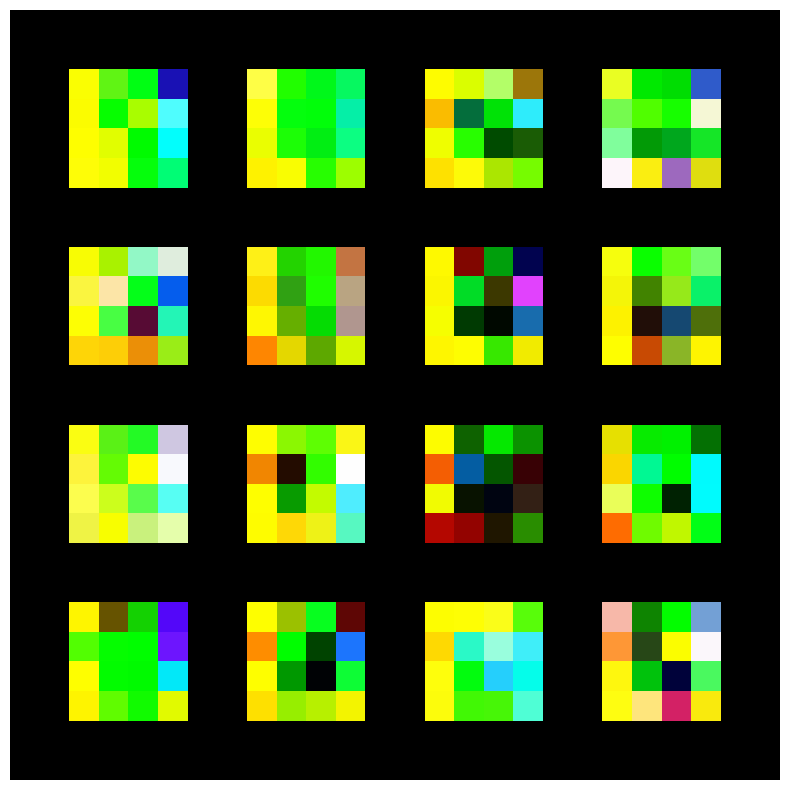

(None, torch.Size([128, 3, 4, 4]))

In [16]:
# TESTING G
g_in = torch.randn(128, 256, device=device)
g_out = g(g_in, alpha=0.5, layer_num=1)
show_images(g_out), g_out.shape

In [17]:
def EMA(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)

In [64]:
def get_dataloader(image_size, batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root='/home/yusuf/python/YMPaperImplementations/paper_implementations/celeba_hq_256', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

    return dataloader

In [19]:
def get_params_with_lr(model):
    mapping_params = []
    other_params = []
    for name, param in model.named_parameters():
        if 'mapping' in name:  # Adjust this condition based on your actual naming convention
            mapping_params.append(param)
        else:
            other_params.append(param)
    return mapping_params, other_params

In [20]:
# First, let's create a function to get the appropriate batch size for each resolution
def get_batch_size(resolution):
    batch_sizes = {
        4: 128,
        8: 128,
        16: 64,
        32: 32,
        64: 16,
        128: 8,
        256: 8
    }
    return batch_sizes.get(resolution, 8) 

In [169]:
# Now sample 30k fake and add them to fid
def resize(images):
    # Resize to 299x299
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
    ])
    return transform(images)

def add_fake_images(g_running, num_images, batch_size, latent_dim, device, layer_num, alpha=1):
    g_running.eval()
    
    with torch.no_grad():
        for _ in tqdm(range(0, num_images, batch_size), desc="Generating images"):
            z = torch.randn(batch_size, latent_dim, device=device)
            batch_images = g_running(z, layer_num=layer_num, alpha=alpha)
        
            resize_batch = resize(batch_images)
            resize_batch = ((resize_batch + 1) * 127.5).clamp(0, 255)
            resize_batch = resize_batch.to(torch.uint8)
            
            # Update FID
            fid.update(resize_batch, real=False)
            
            # Clear GPU cache
            torch.cuda.empty_cache()

def add_real_imgs(data_loader):
    for batch in tqdm(data_loader, desc="Processing real images"):
        imgs, _ = batch
        imgs = resize(imgs)
        imgs = imgs.to(device)
        imgs = ((imgs + 1) * 127.5).clamp(0, 255)
        imgs = imgs.to(torch.uint8)
        fid.update(imgs, real=True)
        
def calculate_and_save_fid(layer_num, iteration, data_loader, g_running, num_fake_images, batch_size, latent_dim, device, fid_file, alpha=1):
    fid.reset()
    add_fake_images(g_running, num_fake_images, batch_size, latent_dim, device, layer_num, alpha=alpha)
    add_real_imgs(data_loader)
    fid_score = fid.compute()
    print(f"FID score for layer {layer_num}, iteration {iteration}: {fid_score.item()}")
    
    with open(fid_file, 'a') as f:
        f.write(f"Layer {layer_num}, Iteration {iteration}: {fid_score.item()}\n")

In [ ]:
## Dynamically create new checkpoint dir with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join('./checkpoints', f'run_{timestamp}')
checkpoint_dir = os.path.join(run_dir, f"checkpoint_{timestamp}")
sample_dir = os.path.join(run_dir, f"sample_{timestamp}")
fid_file = os.path.join(run_dir, 'fid.txt')

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

g = Generator().to(device)
d = Discriminator().to(device)
g_running = Generator().to(device)

g_running.train(False)

fid = FrechetInceptionDistance(feature=2048).to(device)

# Get params of G 
mapping_params, other_params = get_params_with_lr(g)

#g_optimizer = torch.optim.Adam(g.parameters(), lr=0.001, betas=(0.0, 0.99))
g_optimizer = torch.optim.Adam([
    {'params': mapping_params, 'lr': 0.001 * 0.01},  # 0.01 * LR for mapping network
    {'params': other_params, 'lr': 0.001}  # Regular LR for other parts
], betas=(0.0, 0.99))
d_optimizer = torch.optim.Adam(d.parameters(), lr=0.001, betas=(0.0, 0.99))

EMA(g_running, g, 0)

img_size = [4, 8, 16, 32, 64, 128, 256]

layer_num = 1  
start_iter = 0  

total_iters = 100000

g_losses = []
d_losses = []

for layer_num in range(1, 8):
    alpha = 0 
    
    resolution = img_size[layer_num-1]
    batch_size = get_batch_size(resolution)
    #batch_size = 8
    data_loader = get_dataloader(resolution, batch_size)
    dataset = iter(data_loader)
    
    print(f'Training resolution: {resolution}x{resolution}, Batch size: {batch_size}')
    pbar = tqdm(range(total_iters))
    
    for i in pbar:
        d.zero_grad()
        
        try:
            real_imgs, label = next(dataset)
        except (OSError, StopIteration):
            dataset = iter(data_loader)
            real_imgs, label = next(dataset)
        
        # Train D
        real_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        label = label.to(device)
        real_preds = d(real_imgs, layer_num=layer_num, alpha=alpha)
        real_preds = real_preds.mean() - 0.001 * (real_preds**2).mean()
        
        # sample input for G
        #z = torch.randn(real_size, 256, 1, 1).to(device)
        z = torch.randn(real_size, 256, device=device)
        
        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)
        
        gen_preds = d(gen_imgs.detach(), layer_num=layer_num, alpha=alpha)
        gen_preds = gen_preds.mean() 
        
        # Gradient Penalty - GP
        eps = torch.rand((real_size, 1, 1, 1)).to(device)
        x_hat = (eps * real_imgs) + ((1-eps) * gen_imgs.detach())
        x_hat.requires_grad_(True)
        pred_x_hat = d(x_hat, layer_num=layer_num, alpha=alpha)

        WGAN = gen_preds.mean() - real_preds.mean()
        grads = torch.autograd.grad(
            outputs=pred_x_hat, inputs=x_hat,
            grad_outputs=torch.ones_like(pred_x_hat),
            create_graph=True, retain_graph=True
        )[0]
        GP = ((grads.norm(2, dim=1) - 1) ** 2).mean() 

        # WGAN_GP_loss = d_loss
        d_loss = WGAN + 10 * GP
        d_loss.backward()
        d_optimizer.step()

        d_losses.append(d_loss.detach())
        
        # Now lets train the Generator
        g.zero_grad()
        z = torch.randn(real_size, 256, device=device)
        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)
        gen_preds = d(gen_imgs, layer_num=layer_num, alpha=alpha)
        g_loss = -gen_preds.mean()
        g_loss.backward()
        g_optimizer.step()

        g_losses.append(g_loss.detach())
        
        EMA(g_running, g)
    
        inc = (1-alpha) / (len(pbar)-i)
        alpha += inc
        #alpha += 1 / len(pbar)
        #alpha = round(alpha, 2)     
    
        if i % 10000 == 0:
            sample_z = torch.randn(8, 256, device=device)
            sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
            save_image(sample_imgs_EMA, f'{sample_dir}/sample_intro_layer_{layer_num}_iter_{i}.png', nrow=4, normalize=True)
            print(f'Introducing - G_running images images after iter: {i} | alpha: {alpha}')
            show_images(sample_imgs_EMA)
            
            calculate_and_save_fid(layer_num, i, data_loader, g_running, 30000, batch_size, latent_dim, device, fid_file, alpha=alpha)
    
    with torch.no_grad():
        sample_z = torch.randn(8, 256, device=device)
        sample_imgs = g(sample_z, layer_num=layer_num, alpha=alpha)
        sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
        print(f'Images after introducing layer: {layer_num} | alpha: {alpha}')
        print('G images')
        show_images(sample_imgs)
        print('G_running images')
        show_images(sample_imgs_EMA)
        
        calculate_and_save_fid(layer_num, 'final intro', data_loader, g_running, 30000, batch_size, latent_dim, device, fid_file, alpha=alpha)
    
    stabilise_pbar = tqdm(range(total_iters))
    for i in stabilise_pbar:
        d.zero_grad()
        
        try:
            real_imgs, label = next(dataset)
        except (OSError, StopIteration):
            dataset = iter(data_loader)
            real_imgs, label = next(dataset)
        
        # Train D
        real_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        label = label.to(device)
        real_preds = d(real_imgs, layer_num=layer_num, alpha=alpha)
        real_preds = real_preds.mean() - 0.001 * (real_preds**2).mean()
        
        # sample input for G
        #z = torch.randn(real_size, 256, 1, 1).to(device)
        z = torch.randn(real_size, 256, device=device)
        
        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)
        
        gen_preds = d(gen_imgs.detach(), layer_num=layer_num, alpha=alpha)
        gen_preds = gen_preds.mean()
        
        # Gradient Penalty - GP
        eps = torch.rand((real_size, 1, 1, 1)).to(device)
        x_hat = (eps * real_imgs) + ((1-eps) * gen_imgs.detach())
        x_hat.requires_grad_(True)
        pred_x_hat = d(x_hat, layer_num=layer_num, alpha=alpha)

        WGAN = gen_preds.mean() - real_preds.mean()
        grads = torch.autograd.grad(
            outputs=pred_x_hat, inputs=x_hat,
            grad_outputs=torch.ones_like(pred_x_hat),
            create_graph=True, retain_graph=True
        )[0]
        GP = ((grads.norm(2, dim=1) - 1) ** 2).mean() 

        # WGAN_GP_loss = d_loss
        d_loss = WGAN + 10 * GP
        d_loss.backward()
        d_optimizer.step()

        d_losses.append(d_loss.detach())
        
        # Now lets train the Generator
        g.zero_grad()
        #z = torch.randn(real_size, 256, 1, 1).to(device)
        z = torch.randn(real_size, 256, device=device)
        gen_imgs = g(z, layer_num=layer_num, alpha=alpha)
        gen_preds = d(gen_imgs, layer_num=layer_num, alpha=alpha)
        g_loss = -gen_preds.mean()
        g_loss.backward()
        g_optimizer.step()

        g_losses.append(g_loss.detach())
        
        EMA(g_running, g)
        
        if i % 10000 == 0:
            sample_z = torch.randn(8, 256, device=device)
            sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
            save_image(sample_imgs_EMA, f'{sample_dir}/sample_stabilising_layer_{layer_num}_iter_{i}.png', nrow=4, normalize=True)
            print(f'Stabilising - G_running images images after iter: {i} | alpha: {alpha}')
            show_images(sample_imgs_EMA)
            calculate_and_save_fid(layer_num, i, data_loader, g_running, 30000, batch_size, latent_dim, device, fid_file, alpha=alpha)
    
    with torch.no_grad():
        #sample_z = torch.randn(8, 256, 1, 1).to(device)
        sample_z = torch.randn(8, 256, device=device)
        sample_imgs = g(sample_z, layer_num=layer_num, alpha=alpha)
        sample_imgs_EMA = g_running(sample_z, layer_num=layer_num, alpha=alpha)
        save_image(sample_imgs_EMA, f'{sample_dir}/sample_layer_{layer_num}_completed.png', nrow=4, normalize=True)
        print(f'Images after stabilising layer: {layer_num} | alpha: {alpha}')
        print('G images')
        show_images(sample_imgs)
        print('G_running images')
        show_images(sample_imgs_EMA)
        
        calculate_and_save_fid(layer_num, 'final_stable', data_loader, g_running, 30000, batch_size, latent_dim, device, fid_file, alpha=alpha)
        
    torch.save({
        'g_state_dict': g.state_dict(),
        'g_running_state_dict': g_running.state_dict(),
        'd_state_dict': d.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'layer_num': layer_num,
        'iteration': i
    }, f'{checkpoint_dir}/completed_checkpoint_g_and_EMA_layer_{layer_num}.pth')

    
    

Implement a better logging system (output to files and look into clearML)

Given the nature of this model to make a fair comparison I will need metrics not just vision alone. Let's implement FID.

In [146]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=2048).to(device)

'''g = Generator().to(device)
d = Discriminator().to(device)
g_running = Generator().to(device)

# Get params of G 
mapping_params, other_params = get_params_with_lr(g)
#g_optimizer = torch.optim.Adam(g.parameters(), lr=0.001, betas=(0.0, 0.99))
g_optimizer = torch.optim.Adam([
    {'params': mapping_params, 'lr': 0.001 * 0.01},  # 0.01 * LR for mapping network
    {'params': other_params, 'lr': 0.001}  # Regular LR for other parts
], betas=(0.0, 0.99))
d_optimizer = torch.optim.Adam(d.parameters(), lr=0.001, betas=(0.0, 0.99))

#checkpoint = '/home/yusuf/python/YMPaperImplementations/paper_implementations/StyleGAN1/checkpoints/checkpoint_20240809_121043/checkpoint_g_and_EMA_layer_5_81390.pth'
checkpoint = '/home/yusuf/python/YMPaperImplementations/paper_implementations/StyleGAN1/checkpoints/checkpoint_20240809_121043/checkpoint_g_and_EMA_layer_4.pth'
state_dict = torch.load(checkpoint, weights_only=False)
g.load_state_dict(state_dict['g_state_dict'])
d.load_state_dict(state_dict['d_state_dict'])
g_running.load_state_dict(state_dict['g_running_state_dict'])
g_optimizer.load_state_dict(state_dict['g_optimizer_state_dict'])
d_optimizer.load_state_dict(state_dict['d_optimizer_state_dict'])
layer_num = state_dict['layer_num']
start_iter = state_dict['iteration'] + 1
print(f"Resuming from layer {layer_num}, iteration {start_iter}")'''

'g = Generator().to(device)\nd = Discriminator().to(device)\ng_running = Generator().to(device)\n\n#\xa0Get params of G \nmapping_params, other_params = get_params_with_lr(g)\n#g_optimizer = torch.optim.Adam(g.parameters(), lr=0.001, betas=(0.0, 0.99))\ng_optimizer = torch.optim.Adam([\n    {\'params\': mapping_params, \'lr\': 0.001 * 0.01},  # 0.01 * LR for mapping network\n    {\'params\': other_params, \'lr\': 0.001}  # Regular LR for other parts\n], betas=(0.0, 0.99))\nd_optimizer = torch.optim.Adam(d.parameters(), lr=0.001, betas=(0.0, 0.99))\n\n#checkpoint = \'/home/yusuf/python/YMPaperImplementations/paper_implementations/StyleGAN1/checkpoints/checkpoint_20240809_121043/checkpoint_g_and_EMA_layer_5_81390.pth\'\ncheckpoint = \'/home/yusuf/python/YMPaperImplementations/paper_implementations/StyleGAN1/checkpoints/checkpoint_20240809_121043/checkpoint_g_and_EMA_layer_4.pth\'\nstate_dict = torch.load(checkpoint, weights_only=False)\ng.load_state_dict(state_dict[\'g_state_dict\'])\nd.

In [147]:
def show_uint8_images(image_tensor, num_images=16, nrow=4, figsize=(15, 15)):
    """
    Display a grid of uint8 images from a PyTorch tensor.
    Needed for showing images before they are passed to FID score.
    
    Args:
    image_tensor (torch.Tensor): A tensor of shape (N, C, H, W) in uint8 format
    num_images (int): Number of images to display
    nrow (int): Number of images per row in the grid
    figsize (tuple): Figure size
    """
    # Ensure the tensor is on CPU
    image_tensor = image_tensor.cpu()
    
    # Create a grid of images
    grid_img = torchvision.utils.make_grid(image_tensor[:num_images], nrow=nrow, padding=2, normalize=False)
    
    # Convert to numpy and transpose from (C, H, W) to (H, W, C)
    grid_img = grid_img.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.figure(figsize=figsize)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()

Generating images:   0%|          | 0/938 [00:00<?, ?it/s]

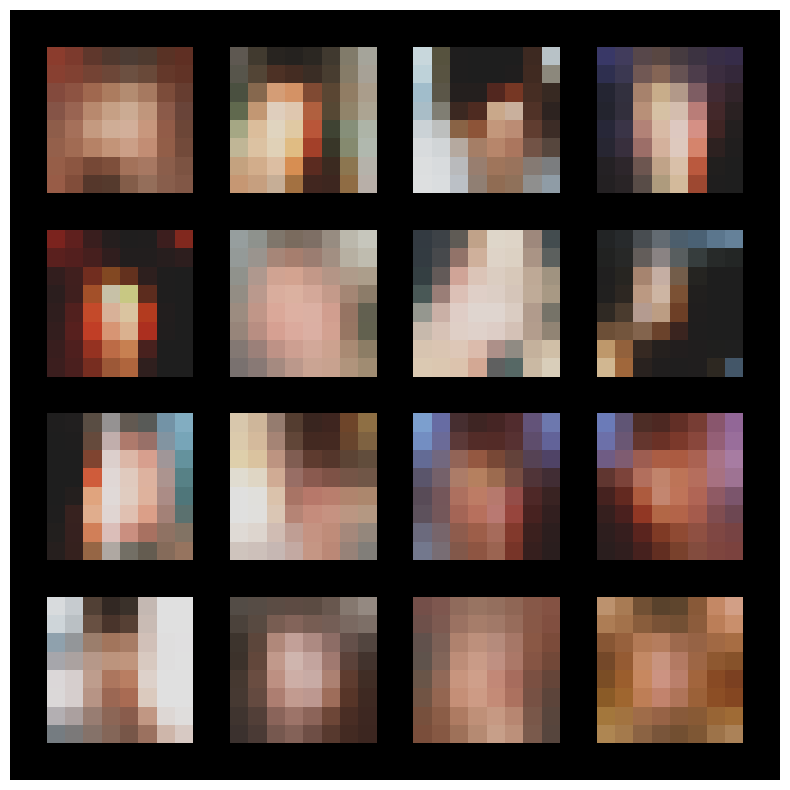

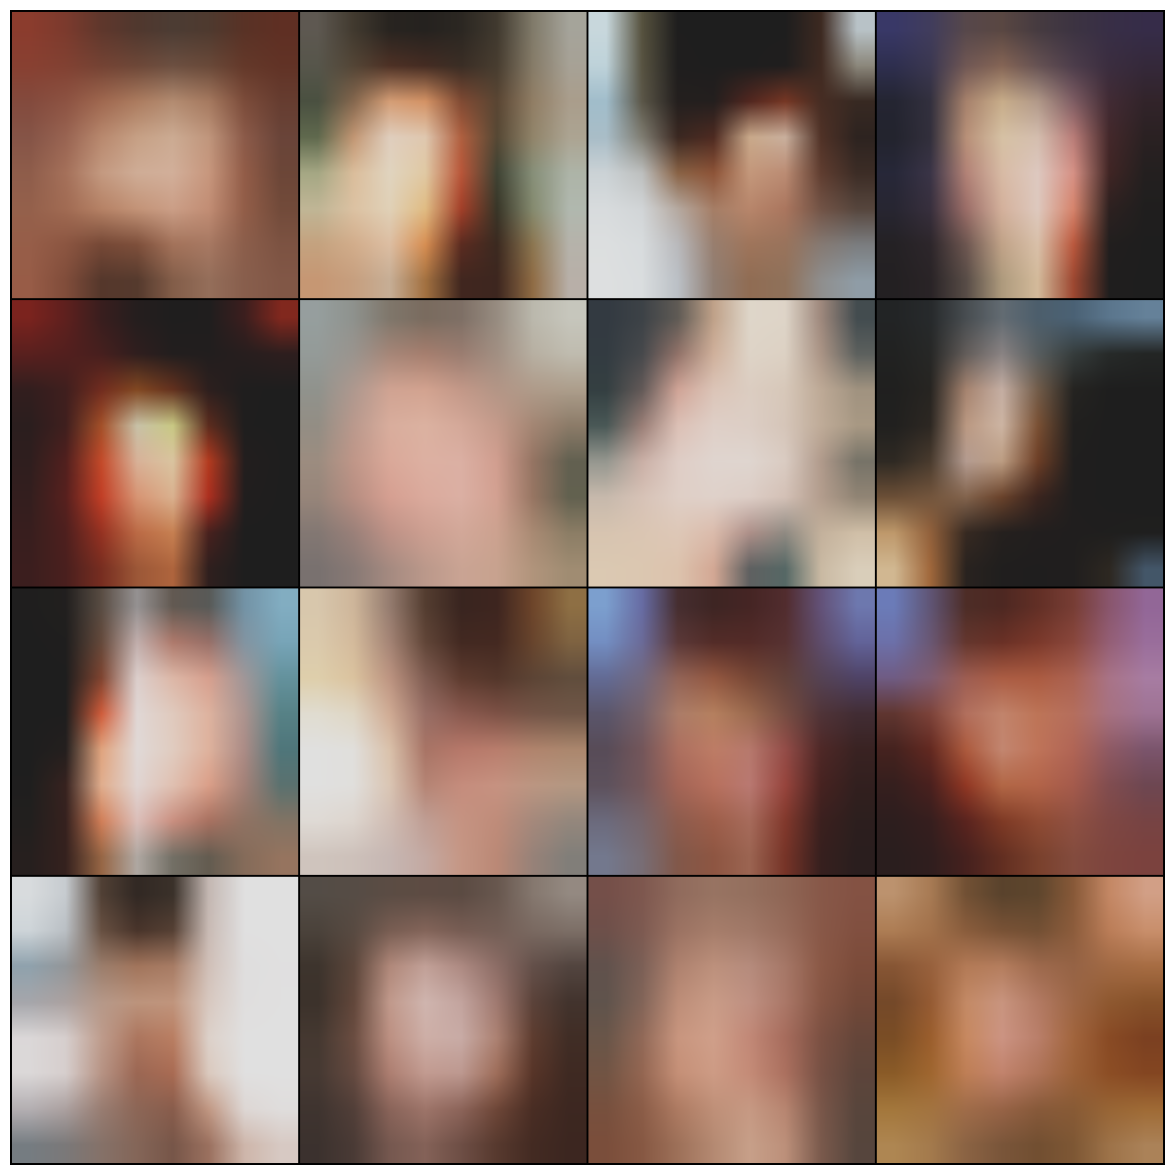

Processing real images:   0%|          | 0/234 [00:00<?, ?it/s]

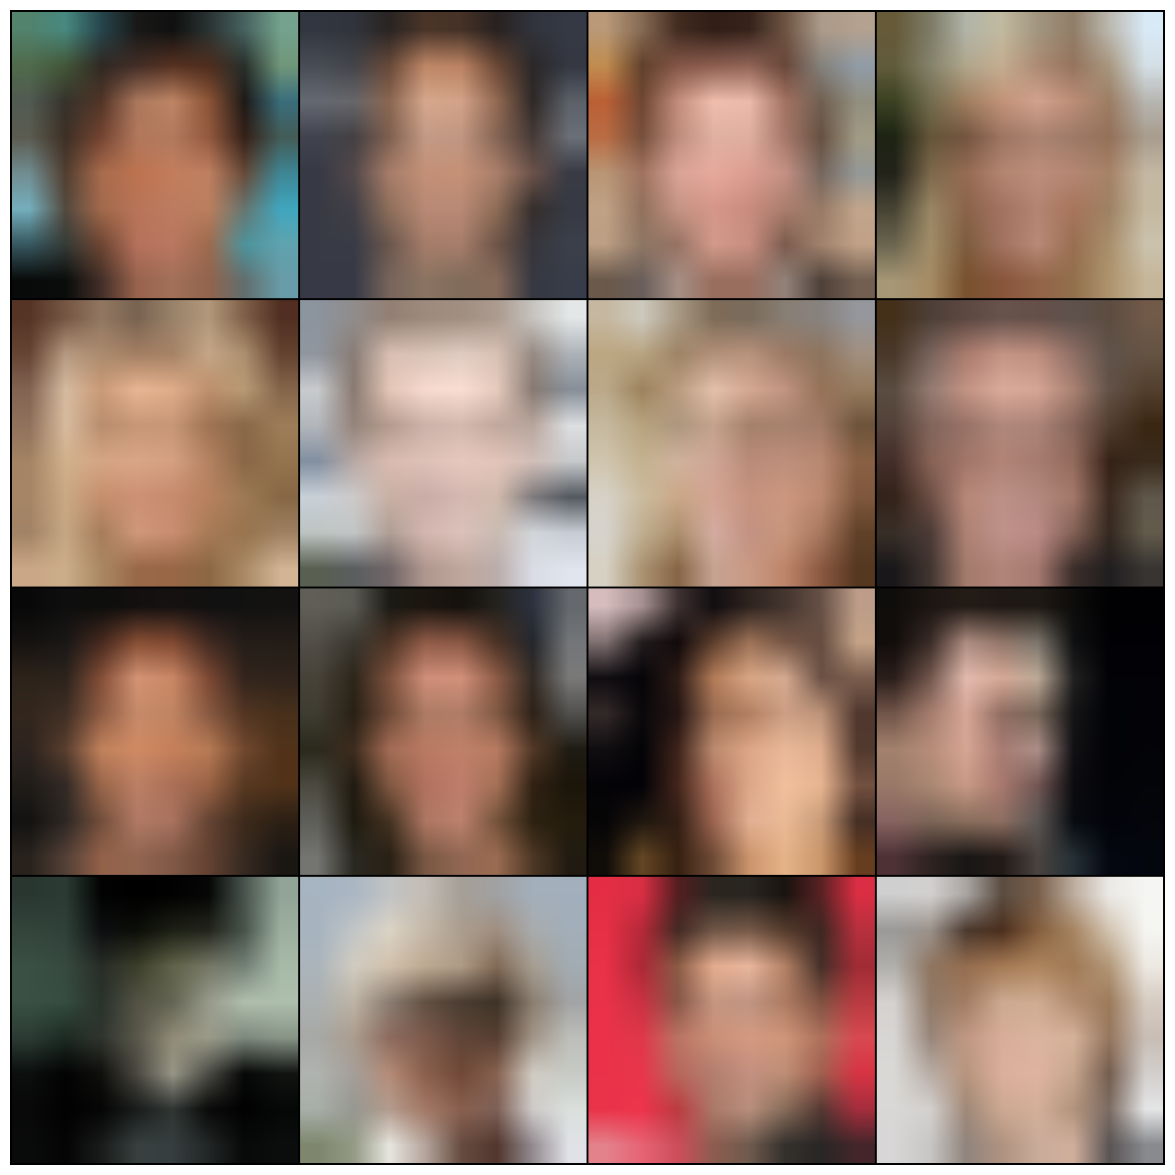

RuntimeError: More than one sample is required for both the real and fake distributed to compute FID

In [166]:
# Now sample 30k fake and add them to fid
def resize(images):
    # Resize to 299x299
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
    ])
    return transform(images)

def add_fake_images(g_running, num_images, batch_size, latent_dim, device, layer_num):
    g_running.eval()
    
    with torch.no_grad():
        for _ in tqdm(range(0, num_images, batch_size), desc="Generating images"):
            z = torch.randn(batch_size, latent_dim, device=device)
            batch_images = g_running(z, layer_num=layer_num, alpha=0)
            show_images(batch_images)
        
            resize_batch = resize(batch_images)
            #show_images(norm_batch)
            #print(norm_batch.min(), norm_batch.max())
            # Images are in range [-1,1] so need to be converted to range 0,255 for uint8 conversion
            resize_batch = ((resize_batch + 1) * 127.5).clamp(0, 255)
            resize_batch = resize_batch.to(torch.uint8)
            show_uint8_images(resize_batch)
            return
            #sys.exit()
            #print(norm_batch.dtype)
            
            # Update FID
            fid.update(resize_batch, real=False)
            
            # Clear GPU cache
            torch.cuda.empty_cache()

fid = FrechetInceptionDistance(feature=2048).to(device)

# Set up device and parameters
num_fake_images = 30000
batch_size = 32
latent_dim = 256  # Adjust based on your model's input size

add_fake_images(g_running, num_fake_images, batch_size, latent_dim, device, 2)

'''for batch in tqdm(data_loader, desc="Processing real images"):
    imgs, _ = batch
    imgs = resize(imgs)
    imgs = imgs.to(device)
    imgs = ((imgs + 1) * 127.5).clamp(0, 255)
    imgs = imgs.to(torch.uint8)
    show_uint8_images(imgs)
    fid.update(imgs, real=True)'''

def add_real_imgs(data_loader):
    for batch in tqdm(data_loader, desc="Processing real images"):
        imgs, _ = batch
        imgs = resize(imgs)
        imgs = imgs.to(device)
        imgs = ((imgs + 1) * 127.5).clamp(0, 255)
        imgs = imgs.to(torch.uint8)
        show_uint8_images(imgs)
        return
        fid.update(imgs, real=True)
        
add_real_imgs(data_loader)
    
# Compute FID score
fid_score = fid.compute()
print(f"FID score: {fid_score.item()}")

In [183]:
pbar = tqdm(range(1000))

a = 0
for i in pbar:
    inc = (1 - a) / (len(pbar) - i)
    a += inc
print(a)

  0%|          | 0/1000 [00:00<?, ?it/s]

1.0
